In [1]:
import pandas as pd
from prophet import Prophet
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

df = pd.read_csv('bike_demand.csv').rename(columns={'datetime':'ds', 'count':'y'})
df.head()

,ds,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,y
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=24*30, freq='H')
future.tail()

20:40:38 - cmdstanpy - INFO - Chain [1] start processing
20:40:39 - cmdstanpy - INFO - Chain [1] done processing


,ds
11601,2013-01-18 19:00:00
11602,2013-01-18 20:00:00
11603,2013-01-18 21:00:00
11604,2013-01-18 22:00:00
11605,2013-01-18 23:00:00


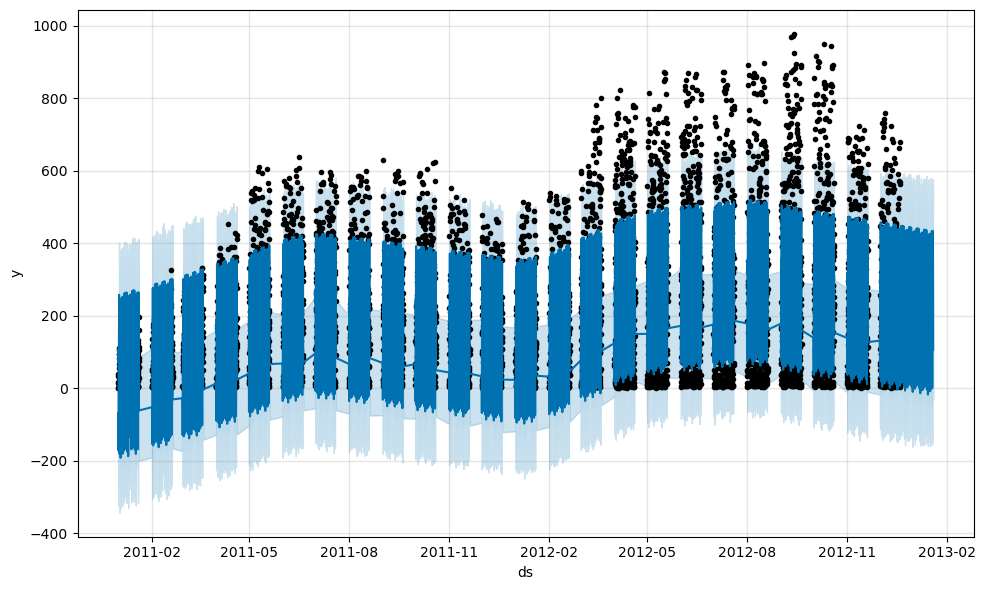

In [3]:
forecast = m.predict(future)
fig = m.plot(forecast)

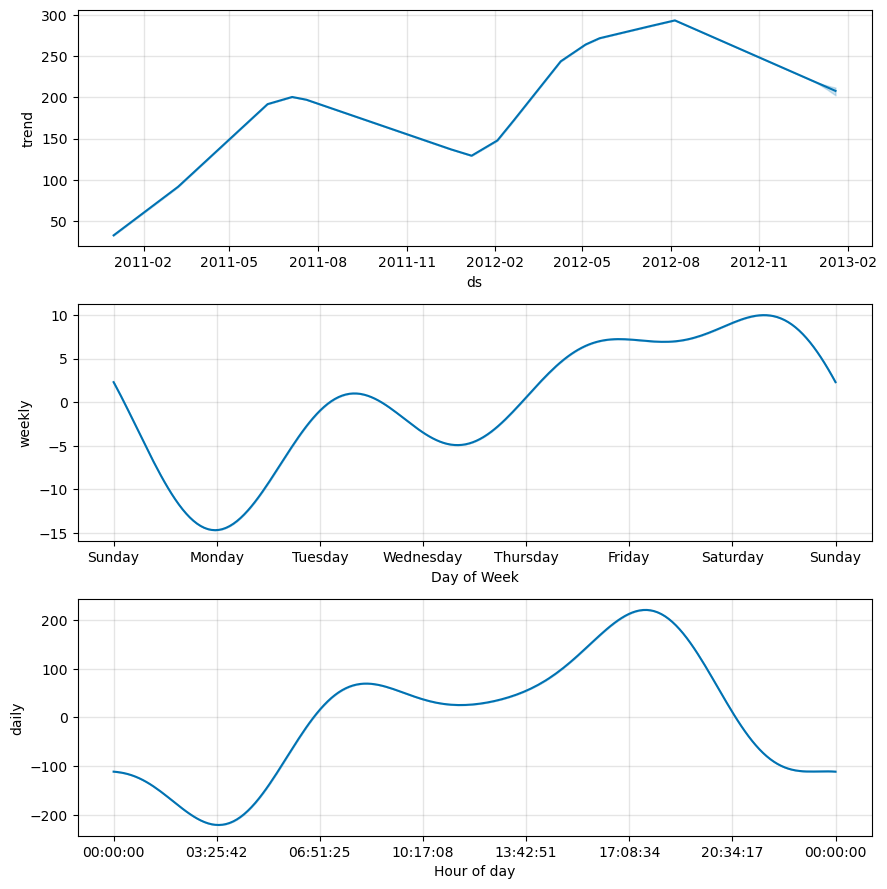

In [4]:
fig = m.plot_components(forecast)

In [6]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
df_p = performance_metrics(df_cv)
print("Mean MAE: ", str(df_p['mae'].mean()))
df_p

Mean MAE:  106.00845004933414


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 23:00:00,17537.814998,132.430416,99.313810,2.347123,0.363875,0.591517,0.745006
1,1 days 00:00:00,17139.986092,130.919770,96.997300,2.144902,0.353324,0.554559,0.757257
2,1 days 01:00:00,17150.302451,130.959163,97.048737,1.776847,0.349485,0.525141,0.759988
3,1 days 02:00:00,17402.959925,131.920279,98.159958,1.472339,0.348682,0.502681,0.747191
4,1 days 03:00:00,17505.837366,132.309627,98.554495,1.536318,0.348682,0.490572,0.739700
...,...,...,...,...,...,...,...,...
141,6 days 20:00:00,25008.463404,158.140644,121.597776,1.248809,0.346287,0.478997,0.630551
142,6 days 21:00:00,24786.510606,157.437323,120.601216,0.783245,0.314953,0.409271,0.642643
143,6 days 22:00:00,24131.632832,155.343596,117.353884,0.550567,0.293125,0.369525,0.659069
144,6 days 23:00:00,22873.843682,151.241012,111.930270,0.433191,0.276354,0.348046,0.690690


In [24]:
def compare_regressors(df):
    columns = df.columns.drop(['ds', 'y'])
    for column in columns:
        m = Prophet()
        m.add_regressor(column)
        m.fit(df)
        df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
        df_p = performance_metrics(df_cv)
        print("Mean MAE with ", column, ": ", str(df_p['mae'].mean()))
    
compare_regressors(df)

Mean MAE with  season :  106.06164124326754
Mean MAE with  holiday :  106.00800950951103
Mean MAE with  workingday :  105.97173277445623
Mean MAE with  weather :  104.29490861767829
Mean MAE with  temp :  101.45973957018938
Mean MAE with  atemp :  101.5427216765286
Mean MAE with  humidity :  105.41255910544885
Mean MAE with  windspeed :  106.05747387257775
Mean MAE with  casual :  76.44076497769971
Mean MAE with  registered :  25.660721780969954


In [26]:
m = Prophet()
m.add_regressor('weather')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('humidity')
m.fit(df)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
df_p = performance_metrics(df_cv)
print("Mean MAE: ", str(df_p['mae'].mean()))

Mean MAE:  100.02664360619438


In [28]:
m = Prophet()
m.add_regressor('weather')
m.add_regressor('atemp')
m.add_regressor('humidity')
m.fit(df)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
df_p = performance_metrics(df_cv)
print("Mean MAE: ", str(df_p['mae'].mean()))

Mean MAE:  99.82124987971682


In [36]:
import itertools
import numpy as np
import pandas as pd

# With different cross validation

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale' : [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ['additive', 'multiplicative'],
    'changepoint_range' : [0.8, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
maes = []

# Use cross validation to evaluate all parameters
print("Finished iterations:")
counter = 1
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('weather')
    m.add_regressor('atemp')
    m.add_regressor('humidity')
    m.fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])
    print(counter, end=",")
    counter+=1

print()
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes

tuning_results.sort_values('mae')

Finished iterations:
1,2,3,

KeyboardInterrupt: 

In [38]:
import optuna

trials_number = 256

def objective(trial) -> float:
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 1.0)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 100.0)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 100.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    changepoint_range = trial.suggest_uniform('changepoint_range', 0.65, 0.95)
    m = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale,
               holidays_prior_scale=holidays_prior_scale, seasonality_mode=seasonality_mode,
               changepoint_range=changepoint_range)
    m.add_regressor('weather')
    m.add_regressor('atemp')
    m.add_regressor('humidity')
    
    m.fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])

    score = df_p['mae'].values[0]
    print("  MAE: {}".format(df_p['mae'].values[0]))
    print("  RMSE: {}".format(df_p['rmse'].values[0]))

    print("  Params for trial " + str(trial.number) + ": ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return score

study_name = 'bike-sharing-study'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="minimize", storage=storage_name, load_if_exists=True,)

study.enqueue_trial({
        "changepoint_prior_scale": 0.05,
        "seasonality_prior_scale": 10.0,
        "holidays_prior_scale": 10.0,
        "seasonality_mode": "additive",
        "changepoint_range": 0.8
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

/tmp/ipykernel_17769/2987140737.py:37: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial({
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(


  MAE: 99.24939567587764
  RMSE: 133.70030483690118
  Params for trial 1: 
    changepoint_prior_scale: 0.05
    seasonality_prior_scale: 10.0
    holidays_prior_scale: 10.0
    seasonality_mode: additive
    changepoint_range: 0.8
  MAE: 99.11804052698558
  RMSE: 133.13045838752922
  Params for trial 2: 
    changepoint_prior_scale: 0.07284196046655966
    seasonality_prior_scale: 82.5933591653912
    holidays_prior_scale: 0.5884291804893144
    seasonality_mode: additive
    changepoint_range: 0.893202554398034
  MAE: 99.47779090696469
  RMSE: 133.37296190938196
  Params for trial 3: 
    changepoint_prior_scale: 0.08852104719414075
    seasonality_prior_scale: 0.0378413582734614
    holidays_prior_scale: 8.831344726240706
    seasonality_mode: additive
    changepoint_range: 0.8613022206640331
  MAE: 90.84442134951473
  RMSE: 124.91753280993004
  Params for trial 4: 
    changepoint_prior_scale: 0.18868683614210943
    seasonality_prior_scale: 0.34888046469929734
    holidays_prior_

  MAE: 104.51655686237413
  RMSE: 134.8725934323051
  Params for trial 29: 
    changepoint_prior_scale: 0.10863414009883325
    seasonality_prior_scale: 0.01188350905042656
    holidays_prior_scale: 5.176166419057365
    seasonality_mode: multiplicative
    changepoint_range: 0.9066473512753754
  MAE: 92.9497158377688
  RMSE: 125.25367171884548
  Params for trial 30: 
    changepoint_prior_scale: 0.3171099201366697
    seasonality_prior_scale: 0.02236757950120847
    holidays_prior_scale: 7.664637555980619
    seasonality_mode: multiplicative
    changepoint_range: 0.8501146119472479
  MAE: 90.3546212353906
  RMSE: 124.05365846914636
  Params for trial 31: 
    changepoint_prior_scale: 0.12494647538787952
    seasonality_prior_scale: 0.12886727249292282
    holidays_prior_scale: 32.58906459970386
    seasonality_mode: multiplicative
    changepoint_range: 0.8045573629979068
  MAE: 89.62532733151666
  RMSE: 122.99030139215849
  Params for trial 32: 
    changepoint_prior_scale: 0.49074

  MAE: 89.58074779401979
  RMSE: 122.91561408396275
  Params for trial 57: 
    changepoint_prior_scale: 0.1567306681905023
    seasonality_prior_scale: 63.4253339651706
    holidays_prior_scale: 1.6597495446654789
    seasonality_mode: multiplicative
    changepoint_range: 0.8625155852951276
  MAE: 89.45773250625604
  RMSE: 122.78062542875615
  Params for trial 58: 
    changepoint_prior_scale: 0.0763528297222753
    seasonality_prior_scale: 31.993057932697642
    holidays_prior_scale: 0.23701352248651397
    seasonality_mode: multiplicative
    changepoint_range: 0.8771766503014108
  MAE: 89.05108117432738
  RMSE: 122.53124832834051
  Params for trial 59: 
    changepoint_prior_scale: 0.24630244293996864
    seasonality_prior_scale: 15.451722115144335
    holidays_prior_scale: 0.46071608647120904
    seasonality_mode: multiplicative
    changepoint_range: 0.9233506147536646
  MAE: 89.14393575827197
  RMSE: 122.56308653103221
  Params for trial 60: 
    changepoint_prior_scale: 0.2200

Process ForkProcess-2400:
Traceback (most recent call last):
  File "/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/multiprocessing/queues.py", line 103, in get
    res = self._recv_bytes()
          ^^^^^^^^^^^^^^^^^^
  File "/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/multiprocessing/connection.py", line 215, in recv_bytes
    buf = self._recv_bytes(maxlength)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/multiprocessing/connection.py",

KeyboardInterrupt: 

In [ ]:
print("\nBest trial:")
trial = study.best_trial

print("  MAE: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
import optuna

trials_number = 512

def objective(trial) -> float:
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 1.0)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 100.0)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 100.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    changepoint_range = trial.suggest_uniform('changepoint_range', 0.65, 0.95)
    m.add_regressor('weather')
    m.add_regressor('atemp')
    m.add_regressor('humidity')
    m = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale,
               holidays_prior_scale=holidays_prior_scale, seasonality_mode=seasonality_mode,
               changepoint_range=changepoint_range)
    
    m.fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])

    score = df_p['mae'].values[0]
    print("  MAE: {}".format(df_p['mae'].values[0]))
    print("  RMSE: {}".format(df_p['rmse'].values[0]))

    print("  Params for trial " + str(trial.number) + ": ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return score

study_name = 'bike-sharing-study2'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="minimize", storage=storage_name, load_if_exists=True,)

study.enqueue_trial({
        "changepoint_prior_scale": 0.05,
        "seasonality_prior_scale": 10.0,
        "holidays_prior_scale": 10.0,
        "seasonality_mode": "additive",
        "changepoint_range": 0.8
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

print("\nBest trial:")
trial = study.best_trial

print("  MAE: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))